In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load Cityscapes dataset

In [2]:
package.loaded.cityscapes = nil
cityscapes = require 'cityscapes'

cityscapes.relative = '../Datasets/Cityscapes/'
nClasses = cityscapes.nClasses -- 19

trainFiles = cityscapes.loadNames('train')
valFiles = cityscapes.loadNames('val')

### Render labels for displaying

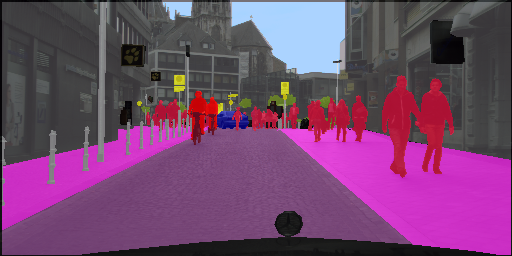

In [3]:
-- example blending
local k = 19
local img, labels = cityscapes.loadSample(trainFiles[k])
itorch.image(cityscapes.renderLabels(labels, img))

In [4]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [5]:
CUDA = true

In [6]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

if CUDA then
    require 'cunn'
end

require 'nngraph'

In [7]:
-- testDir = 'SB overfit/window LR experiments, 2 layers, no constraints/x900/'

-- net = torch.load(testDir .. 'net.t7')
-- losses = torch.load(testDir .. 'loss-history.t7')
-- os.execute('mkdir "' .. testDir .. 'Images (test)" -p')

-- local ints = net:findModules('IntegralSmartNorm')
-- for i = 1,#ints do
--     ints[i].maxX = 1e6
--     ints[i].maxY = 1e6
-- end

In [7]:
-- graph version with conv1 to int2 connection
require 'nngraph'

collectgarbage()

inData = nn.Identity()()

int1 = IntegralSmartNorm(40, cityscapes.dsize[2], cityscapes.dsize[1])(inData) -- 3 -> 120
conv1 = nn.SpatialConvolution(3, 14, 5,5, 1,1, 2,2)(inData) -- 3 -> 14
haar1 = nn.SpatialConvolutionMM(120+14, 15, 1,1,1,1)
    (nn.JoinTable(1,3)({int1, conv1})) -- 120+14 -> 15

int2 = IntegralSmartNorm(16, cityscapes.dsize[2], cityscapes.dsize[1])(nn.LeakyReLU(0.015)(haar1)) -- 15 -> 240
conv2 = nn.SpatialConvolutionMM(14, 14, 5,5, 1,1, 2,2)(nn.LeakyReLU(0.015)(conv1)) -- 14 -> 14
haar2 = nn.SpatialConvolutionMM(240+14, 15, 1,1,1,1)
    (nn.JoinTable(1,3)({int2, conv2})) -- 240+14 -> 15

int3 = IntegralSmartNorm(16, cityscapes.dsize[2], cityscapes.dsize[1])(nn.LeakyReLU(0.015)(haar2)) -- 15 -> 240
conv3 = nn.SpatialConvolutionMM(14, 14, 5,5, 1,1, 2,2)(nn.LeakyReLU(0.015)(conv2)) -- 14 -> 14

nin1 = nn.SpatialConvolutionMM(240+14, 64, 1,1,1,1)
    (nn.JoinTable(1,3)({int3, conv3})) -- 240+14 -> 32
nin2 = nn.SpatialConvolutionMM(64, nClasses, 1,1,1,1)
    (nn.LeakyReLU(0.015)(nin1)) -- 32 -> nClasses

reshape = nn.Reshape(nClasses, cityscapes.dsize[2]*cityscapes.dsize[1])(nin2)
transpose = nn.Transpose({2, 1})(reshape)

net = nn.gModule({inData}, {transpose})

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 180
    ints[i].maxY = 360
end

int1.data.module.gradInput = nil
-- conv1.data.module.gradInput = nil
-- conv1.data.module.updateGradInput = function(self) return torch.CudaTensor() end

if CUDA then
    require 'cunn'
    net:cuda()
end

collectgarbage()

In [12]:
input = torch.CudaTensor(3, cityscapes.dsize[2], cityscapes.dsize[1]):fill(0.1)

timer = torch.Timer()
for k = 1,10 do
    output = net:forward(input)
--     net:backward(input, output)
--     net:clearState()
end
cutorch.synchronize()

print('10 forwards: ' .. timer:time().real)

10 forwards: 11.623017072678	


In [7]:
outputDir = 'Cityscapes segmentation/1 graph 3 layers/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [8]:
net = torch.load(outputDir .. 'net.t7')
ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].smart = true
    ints[i].exact = true
    ints[i].maxX = 180
    ints[i].maxY = 360
end

-- ints[1].gradInput = nil
-- conv1 = net.innode.children[1].children[1].data.module
-- assert(torch.isTypeOf(conv1, nn.SpatialConvolution) or torch.isTypeOf(conv1, nn.SpatialConvolutionMM))
-- conv1.updateGradInput = nn.SpatialConvolution.updateGradInput
-- conv1.updateGradInput = function() return torch.Tensor():typeAs(conv1) end

losses = torch.load(outputDir .. 'loss-history.t7')

In [9]:
torch.manualSeed(666)
cutorch.manualSeed(666)

-- net:reset()
params, gradParams = net:parameters()

In [10]:
losses = {}

In [10]:
criterion = nn.CrossEntropyCriterion(cityscapes.classWeights):type(net.modules[1]:type())

In [11]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 0.9e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 480
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.73,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.000
    }
end

In [22]:
for i = 1,#params do
    local lr = 0.1e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 440
    end
    
    optimStates[i].learningRate = lr
    optimStates[i].learningRateDecay = 0.0001
    optimStates[i].t = 1
end

In [12]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

-- windowDebugger_1:load(outputDir .. 'wd1.t7')
-- windowDebugger_2:load(outputDir .. 'wd2.t7')
-- windowDebugger_3:load(outputDir .. 'wd3.t7')

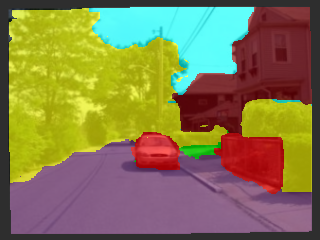

In [14]:
k = 13
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [13]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(1000)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0., 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [14]:
plotLosses(losses)

In [15]:
function predict(net, example)
    local pred = net:forward(example:type(net.modules[1]:type()))
    return select(2, pred:view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:float():clone()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2)*2 + 2, img:size(3))

        retval[{{}, {1, img:size(2)}, {}}]:copy(cityscapes.renderLabels(labels, img))
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2)*3 + 4, img:size(3))
        retval[{{}, {1, img:size(2)}, {}}]:copy(img)
        retval[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(cityscapes.renderLabels(labels, img, 0.8))
        retval[{{}, {img:size(2)*2+5, retval:size(2)}, {}}]:copy(cityscapes.renderLabels(prediction, img, 0.8))
    end
    
    return retval
end

In [16]:
evaluationIdx = {
     25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 
    275, 300, 325, 350, 375, 400, 425, 450, 475, 500
}

-- table.sort(evaluationIdx)

In [17]:
function evaluate(net, files, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local img, labels = cityscapes.loadSample(files[idx])
        
        local input = img:type(net.modules[1]:type())
        local outputs = net:forward(input)
        local target = labels:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%04d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:float():view(cityscapes.dsize[2], cityscapes.dsize[1], nClasses):max(3)):squeeze()))
        end
        
        target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])

        local mask = target:eq(255)
        target[mask] = 7
        outputs[mask:view(-1,1):expandAs(outputs)] = 0
        outputs[{{}, 7}][mask] = 1e4

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

## Training loop

In [ ]:
batchSize = 5
shuffleEvery = math.ceil(#trainFiles / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 10 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 15 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 100 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,#trainFiles do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,10001 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(ints[1])
    windowDebugger_2:add(ints[2])
    windowDebugger_3:add(ints[3])
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
    end
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                cityscapes.loadSample(trainFiles[idx[datasetIdx]])
--                 images[idx[datasetIdx]], 
--                 labels[idx[datasetIdx]]
                --torch.random() % 2 == 0)
            
            if torch.random() % 2 == 0 then
                input = image.flip(input, 3)
                target = image.flip(target, 2)
            else
                target = target:clone()
            end
            
            target = target:view(cityscapes.dsize[1]*cityscapes.dsize[2])
            
            input = input:type(net.modules[1]:type())
            local outputs = net:forward(input)

            local mask = target:eq(255)
            target[mask] = 7
            outputs[mask:view(-1,1):expandAs(outputs)] = 0
            outputs[{{}, 7}][mask] = 1e4
            
            target = target:type(net.modules[1]:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % #trainFiles + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, valFiles, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
--         losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if iter % 5 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 5 or -1) .. ', ' .. os.date()
        )
--         losses[#losses+1] = avgLoss / 5
--         plotLosses(losses)
        avgLoss = 0
    end
    
    if (iter-1) % saveFreq == 0 then
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
        windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

windowDebugger_1:save(outputDir .. 'wd1.t7')
windowDebugger_2:save(outputDir .. 'wd2.t7')
windowDebugger_3:save(outputDir .. 'wd3.t7')

Epoch 0	


Iteration 5, loss = 0.50525450527668, Wed May 17 14:59:30 2017	


Iteration 10, loss = 0.62769074618816, Wed May 17 15:00:38 2017	


Iteration 15, loss = 0.5136284661293, Wed May 17 15:01:59 2017	


Iteration 20, loss = 0.42649523019791, Wed May 17 15:03:07 2017	


Iteration 25, loss = 0.45302578866482, Wed May 17 15:04:27 2017	


Iteration 30, loss = 0.45972485363483, Wed May 17 15:05:35 2017	


Iteration 35, loss = 0.4111999297142, Wed May 17 15:06:55 2017	


Iteration 40, loss = 0.43126534283161, Wed May 17 15:08:04 2017	


Iteration 45, loss = 0.50394551515579, Wed May 17 15:09:24 2017	


Iteration 50, loss = 0.43923595190048, Wed May 17 15:10:33 2017	


Iteration 55, loss = 0.5267170381546, Wed May 17 15:11:53 2017	


Iteration 60, loss = 0.48860519766808, Wed May 17 15:13:00 2017	


Iteration 65, loss = 0.4027893859148, Wed May 17 15:14:20 2017	


Iteration 70, loss = 0.54919611215591, Wed May 17 15:15:29 2017	


Iteration 75, loss = 0.66720176577568, Wed May 17 15:16:49 2017	


Iteration 80, loss = 0.42323520541191, Wed May 17 15:17:57 2017	


Iteration 85, loss = 0.47793933033943, Wed May 17 15:19:17 2017	


Iteration 90, loss = 0.41651612043381, Wed May 17 15:20:26 2017	


Iteration 95, loss = 0.49128702700138, Wed May 17 15:21:46 2017	


Iteration 100, loss = 0.46320703089237, Wed May 17 15:22:54 2017	


Iteration 105, loss = 0.43372147500515, Wed May 17 15:24:54 2017	


Iteration 110, loss = 0.51760015726089, Wed May 17 15:26:02 2017	


Iteration 115, loss = 0.51211886525154, Wed May 17 15:27:22 2017	


Iteration 120, loss = 0.49550576090813, Wed May 17 15:28:30 2017	


Iteration 125, loss = 0.38847647249699, Wed May 17 15:29:50 2017	


Iteration 130, loss = 0.45908955454826, Wed May 17 15:30:59 2017	


Iteration 135, loss = 0.46951206564903, Wed May 17 15:32:20 2017	


Iteration 140, loss = 0.42441801190376, Wed May 17 15:33:28 2017	


Iteration 145, loss = 0.50216809809208, Wed May 17 15:34:49 2017	


Iteration 150, loss = 0.42252026677132, Wed May 17 15:35:57 2017	


Iteration 155, loss = 0.44142686545849, Wed May 17 15:37:22 2017	


Iteration 160, loss = 0.43981620073318, Wed May 17 15:38:31 2017	


Iteration 165, loss = 0.36853463768959, Wed May 17 15:39:51 2017	


Iteration 170, loss = 0.5433005708456, Wed May 17 15:40:59 2017	


Iteration 175, loss = 0.47233407437801, Wed May 17 15:42:19 2017	


Iteration 180, loss = 0.45810807645321, Wed May 17 15:43:27 2017	


Iteration 185, loss = 0.46001066446304, Wed May 17 15:44:47 2017	


Iteration 190, loss = 0.41855520546436, Wed May 17 15:45:56 2017	


Iteration 195, loss = 0.41661213159561, Wed May 17 15:47:16 2017	


Iteration 200, loss = 0.37973273873329, Wed May 17 15:48:24 2017	


Iteration 205, loss = 0.46899809122086, Wed May 17 15:50:25 2017	


Iteration 210, loss = 0.44819307148457, Wed May 17 15:51:33 2017	


Iteration 215, loss = 0.48257204473019, Wed May 17 15:52:53 2017	


Iteration 220, loss = 0.43259229540825, Wed May 17 15:54:01 2017	


Iteration 225, loss = 0.48940117239952, Wed May 17 15:55:22 2017	


Iteration 230, loss = 0.42897521734238, Wed May 17 15:56:30 2017	


Iteration 235, loss = 0.59975894808769, Wed May 17 15:57:51 2017	


Iteration 240, loss = 0.437621935606, Wed May 17 15:58:59 2017	


Iteration 245, loss = 0.43435489714146, Wed May 17 16:00:19 2017	


Iteration 250, loss = 0.46239987552166, Wed May 17 16:01:28 2017	


Iteration 255, loss = 0.43336704671383, Wed May 17 16:02:48 2017	


Iteration 260, loss = 0.44926497578621, Wed May 17 16:03:56 2017	


Iteration 265, loss = 0.4383505654335, Wed May 17 16:05:17 2017	


Iteration 270, loss = 0.46084280729294, Wed May 17 16:06:26 2017	


Iteration 275, loss = 0.4512104600668, Wed May 17 16:07:46 2017	


Iteration 280, loss = 0.44583422720432, Wed May 17 16:08:54 2017	


Iteration 285, loss = 0.45656750261784, Wed May 17 16:10:14 2017	


Iteration 290, loss = 0.45797900974751, Wed May 17 16:11:23 2017	


Iteration 295, loss = 0.46184240996838, Wed May 17 16:12:44 2017	


Iteration 300, loss = 0.50059559822083, Wed May 17 16:13:52 2017	


Iteration 305, loss = 0.46517682135105, Wed May 17 16:16:00 2017	


Iteration 310, loss = 0.40349842131138, Wed May 17 16:17:08 2017	


Iteration 315, loss = 0.4458100104332, Wed May 17 16:18:30 2017	


Iteration 320, loss = 0.45312150835991, Wed May 17 16:19:39 2017	


Iteration 325, loss = 0.45409628987312, Wed May 17 16:21:00 2017	


Iteration 330, loss = 0.43248875141144, Wed May 17 16:22:09 2017	


Iteration 335, loss = 0.47822123408318, Wed May 17 16:23:30 2017	


Iteration 340, loss = 0.47755359470844, Wed May 17 16:24:38 2017	


Iteration 345, loss = 0.48609148383141, Wed May 17 16:25:59 2017	


Iteration 350, loss = 0.47558932483196, Wed May 17 16:27:08 2017	


Iteration 355, loss = 0.47380856275558, Wed May 17 16:28:29 2017	


Iteration 360, loss = 0.47370292186737, Wed May 17 16:29:38 2017	


Iteration 365, loss = 0.44975729703903, Wed May 17 16:30:59 2017	


Iteration 370, loss = 0.46473547518253, Wed May 17 16:32:07 2017	


Iteration 375, loss = 0.41673118114471, Wed May 17 16:33:28 2017	


Iteration 380, loss = 0.46442406415939, Wed May 17 16:34:37 2017	


Iteration 385, loss = 0.48275684356689, Wed May 17 16:35:57 2017	


Iteration 390, loss = 0.38374741315842, Wed May 17 16:37:06 2017	


Iteration 395, loss = 0.42450909614563, Wed May 17 16:38:27 2017	


Iteration 400, loss = 0.43993459939957, Wed May 17 16:39:36 2017	


Iteration 405, loss = 0.43408901691437, Wed May 17 16:41:38 2017	


Iteration 410, loss = 0.43402318358421, Wed May 17 16:42:47 2017	


Iteration 415, loss = 0.43396919310093, Wed May 17 16:44:08 2017	


In [23]:
evaluate(net, valFiles, evaluationIdx,
           (outputDir .. 'Images/'))

In [24]:
local trainEvalIdx = {
    250,  500,  750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 
    2750, 2800, 2900, 100, 2100, 2400
}
evaluate(net, trainFiles, trainEvalIdx,
            (outputDir .. 'Images/train/'))

0.5433619722724	{
  1 : 1.2058424949646
  2 : 0.43333274126053
  3 : 0.67838448286057
  4 : 0.8792958855629
  5 : 0.99473029375076
  6 : 0.4407222867012
  7 : 1.047841668129
  8 : 0.56678110361099
  9 : 0.20234905183315
  10 : 0.45145535469055
  11 : 0.26106426119804
  12 : 0.31521457433701
  13 : 0.64636468887329
  14 : 0.5080738067627
  15 : 0.74293380975723
  16 : 0.17059563100338
  17 : 0.35881227254868
  18 : 0.29971146583557
  19 : 0.31651324033737
  20 : 0.34722033143044
}


## Display predictions for test samples

In [19]:
local filenames = {}
for file in paths.files(relative .. 'images_test/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'images_test/' .. filenames[i]), 320, 240, 'bicubic')
    
    local imgForNet = img:cuda()
    imgForNet:add(-mean)
    imgForNet:div(std)
    
    local prediction = predict(net, imgForNet)
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(testDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 1
end

collectgarbage()

In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}


## Overfit to small number of samples

In [33]:
outputDir = 'SB overfit/momentum, 2 layers, graph/666/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [34]:
torch.manualSeed(666)
cutorch.manualSeed(666)

net:reset()
params, gradParams = net:parameters()

losses = {}

In [35]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 11 and i <= 14) then
        lr = lr * 666 -- 2.5e3 -- lr * 400
    end
    
    optimStates[i] = {
        learningRate = lr,
        momentum = 0.9,
        nesterov = true,
        dampening = 0,
        learningRateDecay = 0.999
    }
end

In [36]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

In [ ]:
idx = {55, 21, 26}
batchSize = #idx
shuffleEvery = 0 -- shuffle data every `shuffleEvery` iterations
outputFreq = 1 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 16 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 16 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

local avgLoss = 0

for iter = 1,999 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(int1.data.module)
    windowDebugger_2:add(int2.data.module)
    
    local batchLoss = 0 -- at current minibatch
    local outputs
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(int1.data.module:type())
            outputs = net:forward(input)
            
            if int1.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int1')
                batchLoss = 0/0
                break
            end
            
            if int2.data.module.outputOnes:lt(0.01):sum() > 0 then
                print('int2')
                batchLoss = 0/0
                break
            end
            
            if (iter-1) % (outputFreq * imgOutputFreq) == 0 then
                local outputImg = comparePredictions(images[idx[datasetIdx]], labels[idx[datasetIdx]], 
                            select(2, outputs:view(240, 320, 8):max(3)):squeeze():float())
                image.save(outputDir .. 'Images/' .. string.format('%03d.png', idx[datasetIdx]), outputImg)
            end

--             for i = 1,target:nElement() do
--                 if target[i] == 0 then
--                     target[i] = 3
--                     outputs[i]:zero()
--                     outputs[{i,3}] = 1e4
--                 end
--             end
            
            target = target:type(int1.data.module:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            
            if batchLoss ~= batchLoss then
                print('1st')
                break
            end
            
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            if int1.data.module.gradXMax[1] ~= int1.data.module.gradXMax[1] then
                print('2nd')
                batchLoss = 0/0
                break
            end
            
            datasetIdx = datasetIdx % #idx + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    if batchLoss ~= batchLoss then
        break
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        optim.adam(feval, params[i], optimStates[i])
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        
        losses[#losses+1] = avgLoss / outputFreq
        avgLoss = 0
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 or #losses == 500 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
--         windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
        
        if #losses == 500 then break end
    end
    
    if iter % 4 == 0 then
        print('Iteration ' .. iter .. ', ' .. os.date())
    end
    
    if lfs.attributes(outputDir .. 'INTERRUPT') then
        os.rename(outputDir .. 'INTERRUPT', outputDir .. 'INTERRUPT_')
        break
    end
end

In [ ]:
local input, target = --jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]]--, 
                -- torch.random() % 2 == 0)
            
target = target:view(240*320):typeAs(net)

-- probs = nn.SoftMax():typeAs(net):forward(net.output)
for k = 1,target:size(1) do
    local logloss = criterion:forward(net.output[k], target[k])
    if logloss ~= logloss then
        print(k)
--         break
    end
end